In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import shutil
import string
import re

# Making sure tensorflow is working properly
print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

# This prevents some error messages caused by reaching memory limits
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [21]:
data_dir = pathlib.Path('/home/addy/.keras/datasets')/'aclImdb'

if data_dir.exists():
    print("Found the 'aclImdb' dataset.")

else:
    print("Downloading 'aclImdb' dataset.")
    
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True)

    data_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    unsup = data_dir/ 'train' / 'unsup'
    if unsup.exists():
        print("Deleting unsupervised texts.")
        shutil.rmtree(unsup)


Found the 'aclImdb' dataset.


In [3]:
# Initializing parameters

batch_size = 64     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

epochs = 10         # The number of training epochs

In [4]:
# Initializing the training dataset

train_ds = tf.keras.utils.text_dataset_from_directory(
  data_dir/'train',
  validation_split=0.2,
  subset="training",
  seed=seed,
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-01-02 14:16:31.980941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-02 14:16:32.394364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3322 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
# Initializing the validation dataset

val_ds = tf.keras.utils.text_dataset_from_directory(
  data_dir/'train',
  validation_split=0.2,
  subset="validation",
  seed=seed,
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir/'test', 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [7]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [10]:
embedding_dim = 64

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=embedding_dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [11]:

# Choosing the tf.keras.optimizers.Adam with 
# the tf.keras.losses.BinaryCrossentropy loss function and
# the tf.metrics.BinaryAccuracy as metric

model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Finally fitting the model to the data in train_ds 
# with val_ds as the validation dataset
# running for 10 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 13s 28ms/step - loss: 0.6908 - binary_accuracy: 0.5372 - val_loss: 0.6592 - val_binary_accuracy: 0.6460
Epoch 2/10
313/313 [==============================] - 7s 22ms/step - loss: 0.4709 - binary_accuracy: 0.7966 - val_loss: 0.3782 - val_binary_accuracy: 0.8504
Epoch 3/10
313/313 [==============================] - 7s 23ms/step - loss: 0.3083 - binary_accuracy: 0.8845 - val_loss: 0.3359 - val_binary_accuracy: 0.8640
Epoch 4/10
313/313 [==============================] - 7s 22ms/step - loss: 0.2444 - binary_accuracy: 0.9105 - val_loss: 0.3256 - val_binary_accuracy: 0.8716
Epoch 5/10
313/313 [==============================] - 7s 23ms/step - loss: 0.2043 - binary_accuracy: 0.9290 - val_loss: 0.3284 - val_binary_accuracy: 0.8770
Epoch 6/10
313/313 [==============================] - 7s 22ms/step - loss: 0.1701 - binary_accuracy: 0.9425 - val_loss: 0.3281 - val_binary_accuracy: 0.8756
Epoch 7/10
313/313 [==============================] - 7s 

In [12]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


391/391 [==============================] - 4s 10ms/step - loss: 0.4740 - binary_accuracy: 0.8518
Loss:  0.474046915769577
Accuracy:  0.8518000245094299


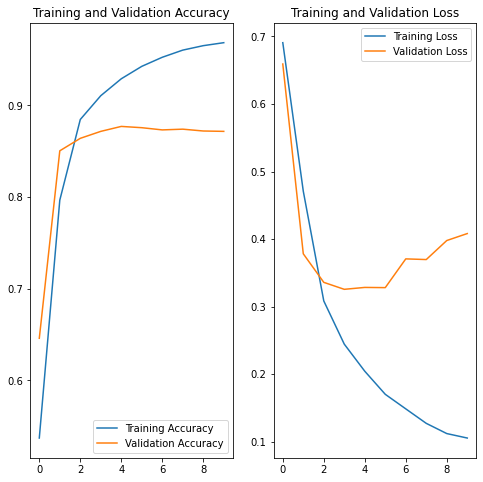

In [13]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(len(vectorize_layer.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [15]:

# Choosing the tf.keras.optimizers.Adam with 
# the tf.keras.losses.BinaryCrossentropy loss function and
# the tf.metrics.BinaryAccuracy as metric

model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Finally fitting the model to the data in train_ds 
# with val_ds as the validation dataset
# running for 10 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 25s 49ms/step - loss: 0.6546 - binary_accuracy: 0.6108 - val_loss: 0.4695 - val_binary_accuracy: 0.7952
Epoch 2/10
313/313 [==============================] - 12s 39ms/step - loss: 0.3686 - binary_accuracy: 0.8483 - val_loss: 0.3220 - val_binary_accuracy: 0.8718
Epoch 3/10
313/313 [==============================] - 12s 38ms/step - loss: 0.2567 - binary_accuracy: 0.9057 - val_loss: 0.3107 - val_binary_accuracy: 0.8720inary_accuracy: 0.9 - ETA: 1s - loss: 0.2623 - bin - ETA: 0s - loss: 0.2592 - binary_accurac
Epoch 4/10
313/313 [==============================] - 12s 38ms/step - loss: 0.1981 - binary_accuracy: 0.9331 - val_loss: 0.3602 - val_binary_accuracy: 0.8616
Epoch 5/10
313/313 [==============================] - 12s 38ms/step - loss: 0.1655 - binary_accuracy: 0.9483 - val_loss: 0.3471 - val_binary_accuracy: 0.8722loss: 0.16
Epoch 6/10
313/313 [==============================] - 12s 37ms/step - loss: 0.1360 - binary_accuracy: 0.9588

In [18]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


391/391 [==============================] - 7s 17ms/step - loss: 0.6123 - binary_accuracy: 0.8422
Loss:  0.6122856736183167
Accuracy:  0.8421599864959717


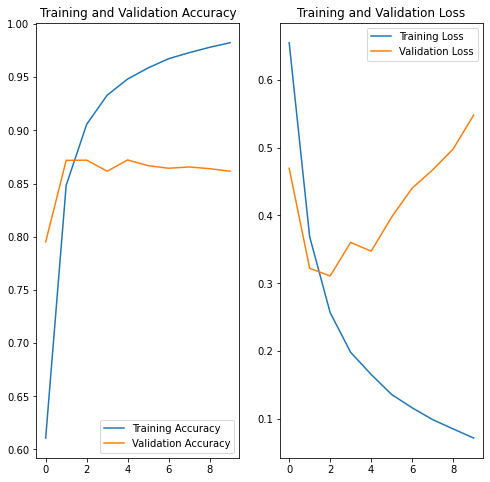

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
